# Indeed job listing data - Exploratory Data Analysis (EDA) 

In [ ]:
# Install necessary packages 
!pip install missingno

In [46]:
# Import necessary packages 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import missingno as msno
%matplotlib inline

## Load the data
Import the data scraped using scraper-countries.py (Sept 20-21 2024), for the following countries: USA, Sweden, France, and Italy. These datasets contain the job listings for the 3 largest cities in respective country, for the job titles _Data Scientist_, _Data Analyst_, _Product Analyst_, and _BI Analyst_.

In [74]:
# Import csv files with scraped data for resp. country 
# Sweden 
df_SWE = pd.read_csv('output/indeed_jobs_Sweden.csv')
# France 
df_FRA = pd.read_csv('output/indeed_jobs_France.csv')
# Italy
df_ITA = pd.read_csv('output/indeed_jobs_Italy.csv')

In [6]:
print(path)

output/indeed_jobs_USA_NY.csv


In [75]:
# USA 
def merge_cities(cities):
    df_NY = pd.read_csv(f'{'output/indeed_jobs_USA_'}{cities[0]}{'.csv'}')
    # df_NY has no country column, add it manually to match the format of the other US cities
    df_NY['country'] = 'USA'
    df_LA = pd.read_csv(f'{'output/indeed_jobs_USA_'}{cities[1]}{'.csv'}')
    df_CHI = pd.read_csv(f'{'output/indeed_jobs_USA_'}{cities[2]}{'.csv'}')
    # Make sure order of columns is the same as for LA and Chicago
    desired_order = df_LA.columns.tolist()
    print('Order of columns: ', desired_order)
    df_NY = df_NY[desired_order]
    # Concactenate rows for US cities 
    df_USA = pd.concat([df_NY, df_LA, df_CHI], ignore_index=True)
    # Verify that it worked 
    df_USA.columns.tolist()==desired_order
    return(df_USA)

df_USA = merge_cities(['NY', 'LA', 'CHI'])


Order of columns:  ['page', 'country', 'job_link', 'search_keyword', 'search_location', 'job_title', 'company_name', 'company_location', 'salary', 'job_description']


## Initial inspection of the data

In [10]:
df_SWE.head(5)
#df_SWE.tail(5)

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,Sweden,https://se.indeed.com/rc/clk?jk=a54f123aa8f7ee...,Data+Analyst,Stockholm,Data Analyst (Data Visualization),Swedium Global Services,Distansjobb in Stockholm,Not available,Data Analyst (Data Visualization) \n \n Swediu...
1,1,Sweden,https://se.indeed.com/rc/clk?jk=5dbbee34feadd8...,Data+Analyst,Stockholm,Data Analyst,Deploja AB,169 73 Solna,Not available,Role: \n \n Website Performance: Web analyst f...
2,1,Sweden,https://se.indeed.com/rc/clk?jk=07cc3fa43334c5...,Data+Analyst,Stockholm,Data Analyst,Cubane Solutions AB,Stockholm,Heltid,Responsibilities \n \n Website Performance: W...
3,1,Sweden,https://se.indeed.com/rc/clk?jk=265b21402a8391...,Data+Analyst,Stockholm,Data Analyst,Sobi,Stockholm,Heltid,Company Description \n Statistics show that w...
4,1,Sweden,https://se.indeed.com/rc/clk?jk=65bfa8c313624f...,Data+Analyst,Stockholm,"Juniora Analysts till Operations, Engineering,...",Deloitte,113 57 Stockholm,Heltid,Företagsbeskrivning \n \n \n Deloitte är en g...


In [11]:
df_FRA.head(5)

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,France,https://www.indeed.fr/rc/clk?jk=3163cc1d8a51ee...,Data+Analyst,Paris (75),CDI - Data analyst KYC - Senior F/H,La Banque Postale,Paris (75),CDI,INTRODUCTION \n Au sein de la direction Data ...
1,1,France,https://www.indeed.fr/rc/clk?jk=71fa252714d41c...,Data+Analyst,Paris (75),Data Analyst F/H,IZI Solutions Durables,Télétravail partiel à La Défense (92),CDI,"À propos \n \n En 2019, le Groupe EDF veut re..."
2,1,France,https://www.indeed.fr/rc/clk?jk=21f25c16a32522...,Data+Analyst,Paris (75),Data analyst,Le Groupe La Poste,Issy-les-Moulineaux (92),CDI,"La Poste Groupe change, nos métiers évoluent. ..."
3,1,France,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,Paris (75),Data Analyst H/F,GROUPE ID SEARCH,Paris (75),"À partir de 35 000 € par an - CDI, Temps plein","Tertialis, société du groupe ID SEARCH, est sp..."
4,1,France,https://www.indeed.fr/rc/clk?jk=8c5cc311877c09...,Data+Analyst,Paris (75),Consultant Débutant Data Analyst en CDI - Pari...,EY,92037 La Défense,CDI,Participer à la digitalisation de nos clients ...


In [12]:
df_ITA.head(5)

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",Business Intelligence (Power BI) - Python- Bus...,Area IT Group,"Roma, Lazio",25.000 € - 40.000 € all'anno,Ricerchiamo Sviluppatori in almeno uno dei seg...
1,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",Power Bi Analyst,Verisure Italy,00144 Roma,Not available,Ti piacerebbe far parte della multinazionale d...
2,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",IT Project Management Internship,Procter & Gamble,"Roma, Lazio",Not available,Job Location Rome Job Description INFORMATI...
3,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",Credit & Collection Data Analyst,Verisure Italy S R L,00144 Roma,Not available,Ti piacerebbe far parte della multinazionale d...
4,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",Aeronautical System Analyst,adecco,"Roma, Lazio",Not available,Per azienda leader a livello globale nella ges...


In [16]:
df_USA.head(5)

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,USA,https://www.indeed.com/rc/clk?jk=5bf7eb172149d...,Data+Analyst,"New+York, NY",Business Analyst (Data products),Aon,"Remote in New York, NY","$80,000 - $95,000 a year - Full-time","Senior Associate Consultant, Data Solutions ..."
1,1,USA,https://www.indeed.com/rc/clk?jk=6b99bd10f1316...,Data+Analyst,"New+York, NY",Data Analyst,NYU Langone,"New York, NY",$32.38 - $39.01 an hour - Temporary,NYU Grossman School of Medicine is one of the...
2,1,USA,https://www.indeed.com/rc/clk?jk=d70c515431fa2...,Data+Analyst,"New+York, NY",Data Analyst,NYU Langone Health,"New York, NY 10016","$67,771.14 - $75,000.00 a year - Full-time",NYU Grossman School of Medicine is one of the...
3,1,USA,https://www.indeed.com/rc/clk?jk=3aa26222eadd6...,Data+Analyst,"New+York, NY","Resy Marketing Data Analyst, Data and Analytics",Amex,"Hybrid work in New York, NY","$60,000 - $110,000 a year",You Lead the Way. We’ve Got Your Back. \n With...
4,1,USA,https://www.indeed.com/rc/clk?jk=3aa564ce173c8...,Data+Analyst,"New+York, NY",2025 University Graduate - Digital Strategy An...,Adobe,"New York, NY 10012","$53,900 - $101,450 a year - Full-time",Our Company Changing the world through digit...


### Check dimensions and data types

In [17]:
# Check dimensions of dfs 
print(f'SWE \t   columns: {df_SWE.shape[1]} \t  rows: {df_SWE.shape[0]}')
print(f'FRA \t   columns: {df_FRA.shape[1]} \t  rows: {df_FRA.shape[0]}')
print(f'ITA \t   columns: {df_ITA.shape[1]} \t  rows: {df_ITA.shape[0]}')
print(f'USA \t   columns: {df_USA.shape[1]} \t  rows: {df_USA.shape[0]}')

SWE 	   columns: 10 	  rows: 320
FRA 	   columns: 10 	  rows: 2200
ITA 	   columns: 10 	  rows: 769
USA 	   columns: 10 	  rows: 1317


In [18]:
# Check data types
df_SWE.info() 
# Most columns are of type 'Dtype object'
# Convert columns with strings only to string data type to optimize performance
# Mixed columns with both numbers and strings: company_location, salary, job_link (url) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   page              320 non-null    int64 
 1   country           320 non-null    object
 2   job_link          320 non-null    object
 3   search_keyword    320 non-null    object
 4   search_location   320 non-null    object
 5   job_title         320 non-null    object
 6   company_name      320 non-null    object
 7   company_location  320 non-null    object
 8   salary            320 non-null    object
 9   job_description   320 non-null    object
dtypes: int64(1), object(9)
memory usage: 25.1+ KB


In [76]:
# Dictionary specifying column names and desired data types
dtype_dict = {
    'page': 'int64',  
    'country': 'string', 
    'job_link': 'object', 
    'search_keyword': 'string', 
    'search_location': 'string', 
    'job_title': 'string', 
    'company_name': 'string', 
    'company_location': 'object', 
    'salary': 'object', 
    'job_description': 'string'
}

# Convert objects to strings 
df_SWE = df_SWE.astype(dtype_dict)

# Output new data types
print(df_SWE.dtypes) # Is string[python] not dtype string?

page                         int64
country             string[python]
job_link                    object
search_keyword      string[python]
search_location     string[python]
job_title           string[python]
company_name        string[python]
company_location            object
salary                      object
job_description     string[python]
dtype: object


In [77]:
# Do the same for the other datasets 
df_FRA = df_FRA.astype(dtype_dict)
df_ITA = df_ITA.astype(dtype_dict)
df_USA = df_USA.astype(dtype_dict)

## Some descriptive statistics

In [22]:
# Describe (numerical) columns  
df_SWE.describe(include='all')

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
count,320.000000,320,320,320,320,320,320,320,320,320
unique,NaN,1,320,4,3,198,198,88,11,263
top,NaN,Sweden,https://se.indeed.com/rc/clk?jk=a54f123aa8f7ee...,Data+Scientist,Stockholm,Data Analyst,Volvo Group,Stockholm,Not available,Who is Infinitas Learning? \n For everyone who...
freq,NaN,320,1,144,225,22,9,87,183,4
mean,2.453125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.734128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
def desc_categorical(data):
    # Get frequency counts for each categorical column
    string_columns = data.select_dtypes(include='string').drop(columns='job_description') # Skip job description! 
    # Get frequency counts for the categorical columns with mixed data types (strings and numbers)
    object_columns = data.select_dtypes(include='object').drop(columns='job_link')

    # Loop through the columns and print value counts
    for col in string_columns.columns:
        print(f'Value counts for column: {col}\n{string_columns[col].value_counts()}\n')
    for col in object_columns.columns:
        print(f'Value counts for column: {col}\n{object_columns[col].value_counts()}\n')

desc_categorical(df_SWE) 

Value counts for column: country
country
Sweden    320
Name: count, dtype: Int64

Value counts for column: search_keyword
search_keyword
Data+Scientist     144
Product+Analyst    100
BI+Analyst          41
Data+Analyst        35
Name: count, dtype: Int64

Value counts for column: search_location
search_location
Stockholm    225
Göteborg      72
Malmö         23
Name: count, dtype: Int64

Value counts for column: job_title
job_title
Data Analyst                                           22
Systemutvecklare                                       20
Data Scientist                                         15
Business Analyst                                       10
Senior Data Scientist                                   6
                                                       ..
Senior Logistics Analyst                                1
Senior PIM Consultant                                   1
Analyst Relations and Market Intelligence Manager       1
Senior Principal Product Analyst | Candy C

### Preliminary observations, Swedish job listings:
- __Most frequent job titles__: Data Analyst, systemutvecklare, Data Scientist.
- __Most frequent company__: Volvo Group. 
- __Salary ranges__: Few numerical values are provided.

In [79]:
df_FRA.describe(include='all')

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
count,2200.000000,2200,2200,2200,2200,2200,2200,2200,2200,2200
unique,NaN,1,2200,4,3,1213,718,256,165,1311
top,NaN,France,https://www.indeed.fr/rc/clk?jk=3163cc1d8a51ee...,Data+Analyst,Paris (75),Data Analyst H/F,AXA,Paris (75),Temps plein,Not available
freq,NaN,2200,1,757,1949,34,64,582,512,51
mean,17.454091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,13.220097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,15.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,27.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
desc_categorical(df_FRA) 

Value counts for column: country
country
France    2200
Name: count, dtype: Int64

Value counts for column: search_keyword
search_keyword
Data+Analyst       757
Product+Analyst    662
BI+Analyst         463
Data+Scientist     318
Name: count, dtype: Int64

Value counts for column: search_location
search_location
Paris (75)        1949
Lyon (69)          210
Marseille (13)      41
Name: count, dtype: Int64

Value counts for column: job_title
job_title
Data Analyst H/F                                                   34
Data Analyst                                                       19
Data Analyst (F/H)                                                 18
Data Analyst Intern                                                17
Senior Product Data Analyst                                        13
                                                                   ..
Treasury Senior Analyst - Expert                                    1
Ingénieur systèmes Windows - secteur de l'assurance H/F

### Preliminary observations, French job listings:
- Many listings compared to Sweden. 
- __Most frequent job titles__: Data Analyst H/F (many similar names for this title, e.g. Data Analyst, Data Analyst F/H). 
- __Most frequently mentioned company__: AXA.
- __Company location__: Includes some information about télétravail (especially common in Paris).  
- __Salary ranges__: Need to split column to be able to draw any conclusions.

In [27]:
df_ITA.describe(include='all')

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
count,769.000000,769,769,769,769,769,769,769,769,769
unique,NaN,1,769,4,3,469,309,96,15,554
top,NaN,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Milano, Lombardia",Data Scientist,BIP - Business Integration Partners,"Milano, Lombardia",Not available,Company: TELEPASS ASSICURA\n \n \n \n \n ...
freq,NaN,769,1,419,540,32,39,207,746,5
mean,5.954486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,5.317205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
desc_categorical(df_ITA) 

Value counts for column: country
country
Italy    769
Name: count, dtype: Int64

Value counts for column: search_keyword
search_keyword
Data+Analyst       419
Data+Scientist     170
Product+Analyst     90
BI+Analyst          90
Name: count, dtype: Int64

Value counts for column: search_location
search_location
Milano, Lombardia    540
Roma, Lazio          203
Napoli, Campania      26
Name: count, dtype: Int64

Value counts for column: job_title
job_title
Data Scientist                                              32
Data Analyst                                                23
Business Analyst                                            14
Senior Data Analyst                                         10
Pricing Analyst                                              5
                                                            ..
BUSINESS ANALYST - BI                                        1
BI Analyst                                                   1
Process Analyst                      

### Preliminary observations, Italian job listings:
- Many listings compared to Sweden, but less than France.
- __Most frequent job titles__: Data Analyst, Data Scientist, Product Analyst. 
- __Most frequently mentioned company__: BIP - Business Integration Partners. 
- __Company location__: Milano. Also remote in Milano is relatively common (as is Rome).
- __Salary ranges__: Few numerical entries provided. 

In [97]:
df_USA.describe(include='all')

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
count,1317.000000,1317,1317,1317,1317,1317,1317,1317,1317,1317
unique,NaN,1,1317,4,3,739,470,185,525,823
top,NaN,USA,https://www.indeed.com/rc/clk?jk=5bf7eb172149d...,Data+Analyst,"New+York, NY",Data Analyst,Citi,"New York, NY",Full-time,"Guy Carpenter & Company, LLC is seeking candid..."
freq,NaN,1317,1,522,771,29,44,269,236,6
mean,6.425968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.684258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
desc_categorical(df_USA) 

Value counts for column: country
country
USA    1317
Name: count, dtype: Int64

Value counts for column: search_keyword
search_keyword
Data+Analyst       522
Data+Scientist     396
BI+Analyst         315
Product+Analyst     84
Name: count, dtype: Int64

Value counts for column: search_location
search_location
New+York, NY       771
Chicago, IL        444
Los+Angeles, CA    102
Name: count, dtype: Int64

Value counts for column: job_title
job_title
Data Analyst                                                  29
Business Analyst                                              25
Senior Business Analyst                                       19
Senior Machine Learning Engineer                              13
Senior Data Analyst                                           11
                                                              ..
Analyst - Innovation and Solutions III                         1
Analyst, Commerce                                              1
Product Owner – Digital Medi

### Preliminary observations, American job listings:
- Number of listings are less than for France. 
- __Most frequent job titles__: Data Analyst, Data Scientist, BI analyst. 
- __Most frequently mentioned company__: Citi. 
- __Company location__: New York.  
- __Salary ranges__: Need to split column to draw conclusions. 

### Conclusions
- The following columns needs to be cleaned: search_keyword, job_title, job_description, company_location.   
- The salary column should be split into two columns (separate numeric vs string content).    
- Job titles appear to vary somewhat between countries (since top 3 ones were different for different countries). 


## Data reduction and data cleaning
Handle missing and duplicate data entries. Remove unnecessary columns (if any). 
Clean and preprocess the data to handle anomalies and outliers. 

<Axes: >

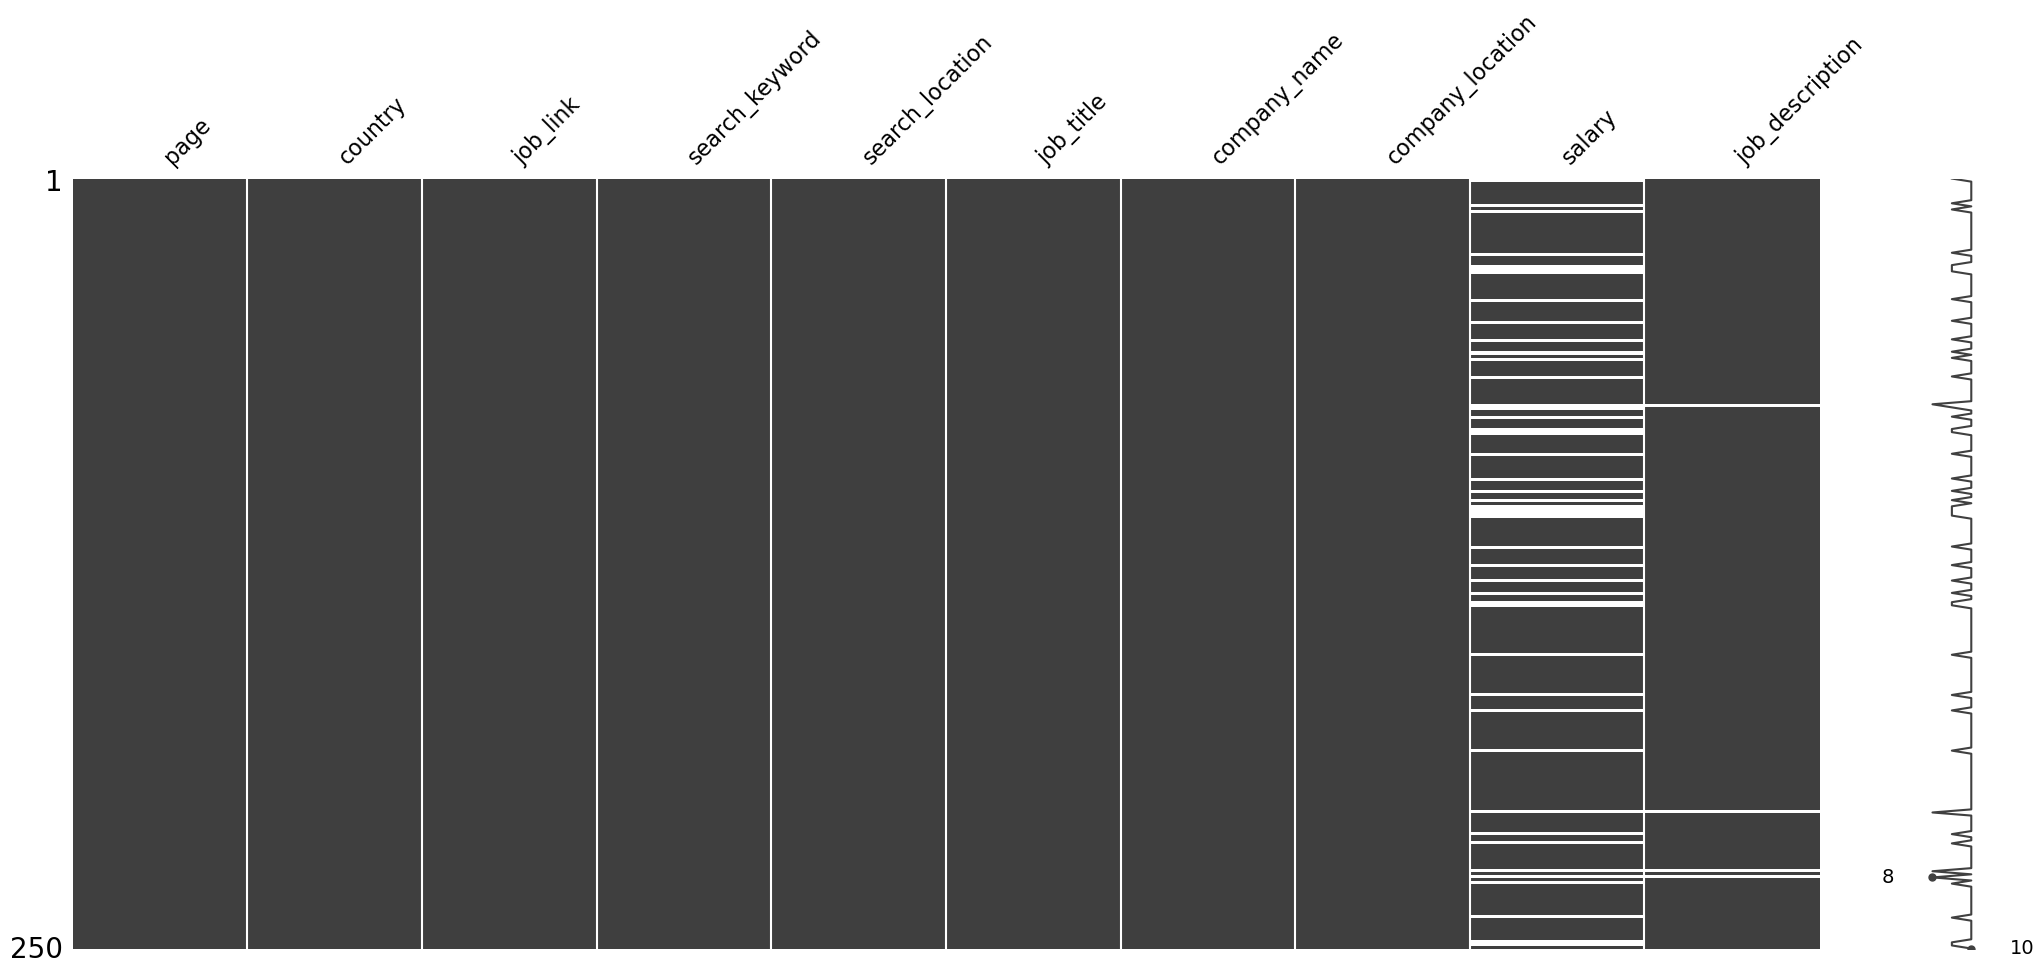

In [81]:
# Handle missing values 
# The scraper labels cells as 'Not available' when there is no value. Change these to NaN. 
# Replace 'Not available' with NaN
df_SWE.replace('Not available', np.nan, inplace=True)
df_FRA.replace('Not available', np.nan, inplace=True) 
df_ITA.replace('Not available', np.nan, inplace=True)
df_USA.replace('Not available', np.nan, inplace=True)

df_FRA.isnull().sum() # Missing salary and job description entries 
df_SWE.isnull().sum() # Missing salary entries 
df_ITA.isnull().sum() # Missing salary entries 
df_USA.isnull().sum() # Missing salary entries 

# Salary entries will be handled later when columns are split 
# For now we do not drop these rows (we are not primarily interested in salaries)

# Visualize missing data patterns using missingno
msno.matrix(df_FRA.sample(250))

In [92]:
# Look into the missing descriptions for French job listings (seems that request was blocked)
df_FRA.isnull().sum()
df_FRA[df_FRA['job_description'].isnull()]

# Manual imports of missing job descriptions from URLs 
df_FRA_missing = pd.read_csv('df_FRA_missing_data.csv')

df_FRA_missing.head()

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description_new
0,11,France,https://www.indeed.fr/rc/clk?jk=cce878d76d9b30...,Data+Analyst,Paris (75),Business Analyst Customer Data 360 H/F,AIR FRANCE KLM,Roissy-en-France (95),CDI,Air France KLM recrute :\n\nVous rejoignez l'é...
1,11,France,https://www.indeed.fr/rc/clk?jk=56a9127952012f...,Data+Analyst,Paris (75),Senior Data Analyst - Paris,Aircall,Paris (75),NaN,Paris\nG&A – 13008 - Data /\nFull Time /\nHybr...
2,11,France,https://www.indeed.fr/rc/clk?jk=f43bcf87ea7bcd...,Data+Analyst,Paris (75),Marketing Business Analyst - (CDD 6 mois),Deliveroo,Paris (75),NaN,Why Deliveroo\n\nOur mission is to transform t...
3,11,France,https://www.indeed.fr/rc/clk?jk=85a29d308f4fa3...,Data+Analyst,Paris (75),ANALYSTE DE DONNEES H/F,Groupe Agrica,Paris (75),NaN,Vous ne nous connaissez pas encore ?\nLe Group...
4,11,France,https://www.indeed.fr/rc/clk?jk=fc6f290a6f389e...,Data+Analyst,Paris (75),Data Analyst Intern,Upflow,Paris (75),NaN,About Upflow\nUpflow revolutionizes the way B2...


In [127]:
# Merge the DataFrames based on the 'job_link' column
merged_df = pd.merge(df_FRA, df_FRA_missing, on=['job_link'])
merged_df = pd.merge(df_FRA, df_FRA_missing[['job_link', 'job_description_new']], on='job_link', how='left')
# Save the job description as only one column (based on when it is not NaN)
merged_df['job_description'] = merged_df['job_description'].combine_first(merged_df['job_description_new'])
merged_df.drop('job_description_new', axis=1, inplace=True)
# Verify that there are no missing values in job_description now
merged_df.isnull().sum()

page                  0
country               0
job_link              0
search_keyword        0
search_location       0
job_title             0
company_name          0
company_location      0
salary              378
job_description       0
dtype: int64

In [62]:
# check for potential duplicates 
# nunique() 
# unique()
# also calculate percentage of missing values for each column 

In [ ]:
# Encoding issues in strings, e.g.: \n, \nG&A

# need to clean search_keyword (contains +)

# need to remove \n for job description column 

# use later on quantitative columns 
#df_SWE.describe()

# Maybe add scraped date column? Good to keep

## Feature engineering 

In [ ]:
# split column to separate numerical values for salary 

# keyword count? 

# merge all of the countries to be able to compare all data. 
# Perhaps should have been done above so that selection could just be done to filter data....

## Univariate analysis 


In [ ]:
# simplest is for payment 
# histograms

# simple word clouds 

## Bivariate analysis 

In [12]:
## Visualization

## Conclusions 
TBA.
Also interesting to look into 'Recruitment process' and 'Interview' process since there is data about that in the dataset?